In [2]:
name = '1403-minstrokes4-maxstrokes64-jumping-0_01-whiteonblack-242-6'
model_path = 'model/' + name + ".h5"

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input, MaxPool2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np

class DoodleSDQModel():
    def __init__(self, global_input_size, local_input_size, output_size):
        #super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size
        
        self.model = self._create_model()
        
        # class weight: down=1, up=0.5
        self.class_weight = {i:1 if i<121 else 0.5 for i in range(output_size)}
        
        
    def _create_model(self):
        local_input = tf.keras.Input(shape=self.local_input_size)
        global_input = tf.keras.Input(shape=self.global_input_size)
        
        inputs = [global_input, local_input]
        
        x_local = self._create_local_CNN(local_input)
        x_global = self._create_global_CNN(global_input)
        
        x = Concatenate(axis=1)([x_global, x_local])
        
        x = Dense(2048)(x)
        x = Dropout(.5)(x)
        x = Activation("relu")(x)
        x = Dense(self.output_size)(x)
        outputs = Activation("softmax") (x)
        return Model(inputs, outputs, name="doodle_dqn")

    def _create_global_CNN(self, input):
        
        x = Conv2D(32, (8,8), strides=(4,4), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (4,4), strides=(2,2), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        
        return x

    def _create_local_CNN(self, input):
        x = Conv2D(128, (11,11), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        return x
    
    def train(self,training_gen, validation_data, epochs, init_epoch=0):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=15, verbose=1,)
        tensorboard = TensorBoard(
                              log_dir='logs/'+name,
                              histogram_freq=0,
                              write_images=True
                            )
        
        self.epochs = epochs
        self.model.compile(optimizer=Adam(lr=.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(training_gen,\
                                      validation_data=validation_data, \
                                      validation_steps= len(validation_data),\
                                      epochs=epochs, \
                                      initial_epoch=init_epoch,\
                                      callbacks=[reduce_lr, tensorboard], \
#                                       class_weight=self.class_weight, \
                                      verbose=1)
    
    def plot(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
#     def _create_dense(self):
#         input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
#         model = Sequential()
#         model.add(Input(shape=input_shape))
#         model.add(Dense(256, activation="relu"))
#         model.add(Dense(self.output_size, activation="softmax"))
#         return model

#     def call(self, inputs, patches):
#         print("call")
#         global_input = inputs
#         local_input = patches
#         global_features = self.model_global(global_input)
#         local_features = self.model_local(local_input)
        
#         x = Concatenate(axis=1)([global_features, local_features])
#         y_pred = self.dense(x)
        
#         return y_pred


In [3]:
from random_stroke_generator import RandomStrokeGenerator

In [4]:
training_gen = RandomStrokeGenerator(batch_size=484,num_data=4840, min_strokes=4, max_strokes=64)
valid_gen = RandomStrokeGenerator(batch_size=242, num_data=968, min_strokes=4, max_strokes=64)

In [4]:
global_size = (84,84,4)
local_size = (11,11,2)
model1 = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)
model_base = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)


In [ ]:
# model1.model.summary()

In [ ]:
# from tensorflow import keras

# keras.utils.plot_model(model1.model, "doodle_sdq.png", show_shapes=True)

In [6]:
model1.train(training_gen, valid_gen, 60, init_epoch=0)

Epoch 1/60
10/10 [==============================] - 1s 94ms/step - loss: 5.7631 - accuracy: 0.0112 - val_loss: 5.4841 - val_accuracy: 0.0103 - lr: 0.0030
Epoch 2/60
10/10 [==============================] - 1s 66ms/step - loss: 5.4704 - accuracy: 0.0120 - val_loss: 5.4138 - val_accuracy: 0.0227 - lr: 0.0030
Epoch 3/60
10/10 [==============================] - 1s 67ms/step - loss: 5.2739 - accuracy: 0.0316 - val_loss: 4.9168 - val_accuracy: 0.0630 - lr: 0.0030
Epoch 4/60
10/10 [==============================] - 1s 68ms/step - loss: 4.4992 - accuracy: 0.0957 - val_loss: 4.0673 - val_accuracy: 0.1457 - lr: 0.0030
Epoch 5/60
10/10 [==============================] - 1s 68ms/step - loss: 3.9157 - accuracy: 0.1698 - val_loss: 3.5499 - val_accuracy: 0.2407 - lr: 0.0030
Epoch 6/60
10/10 [==============================] - 1s 68ms/step - loss: 3.6799 - accuracy: 0.2171 - val_loss: 3.4790 - val_accuracy: 0.2655 - lr: 0.0030
Epoch 7/60
10/10 [==============================] - 1s 70ms/step - loss: 3.5

Epoch 50/60
10/10 [==============================] - 1s 70ms/step - loss: 3.0155 - accuracy: 0.3731 - val_loss: 2.9790 - val_accuracy: 0.3802 - lr: 8.1000e-05
Epoch 51/60
 9/10 [==========================>...] - ETA: 0s - loss: 3.1483 - accuracy: 0.3455
Epoch 00051: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-05.
10/10 [==============================] - 1s 68ms/step - loss: 3.1312 - accuracy: 0.3488 - val_loss: 2.8803 - val_accuracy: 0.3998 - lr: 8.1000e-05
Epoch 52/60
10/10 [==============================] - 1s 69ms/step - loss: 3.0959 - accuracy: 0.3541 - val_loss: 3.1210 - val_accuracy: 0.3399 - lr: 2.4300e-05
Epoch 53/60
10/10 [==============================] - 1s 69ms/step - loss: 3.0503 - accuracy: 0.3667 - val_loss: 2.9629 - val_accuracy: 0.3698 - lr: 2.4300e-05
Epoch 54/60
10/10 [==============================] - 1s 71ms/step - loss: 3.0700 - accuracy: 0.3671 - val_loss: 2.9606 - val_accuracy: 0.3926 - lr: 2.4300e-05
Epoch 55/60
10/10 [=======================

In [ ]:
! tensorboard --logdir "logs/" + name

In [ ]:
X, y = training_gen.__getitem__(1)

In [7]:
model1.model.evaluate(training_gen)

10/10 [==============================] - 1s 141ms/step - loss: 3.0056 - accuracy: 0.3676


[3.0055863857269287, 0.3675619959831238]

In [8]:
model1.model.evaluate(valid_gen)

4/4 [==============================] - 0s 68ms/step - loss: 2.9240 - accuracy: 0.4194


[2.9239509105682373, 0.4194214940071106]

In [ ]:
pred = model1.model.predict(X)
print(pred)

In [ ]:
print(y)

In [ ]:
import numpy as np
y_pred = np.argmax(pred, axis=1)
print(y_pred[y_pred!=y])

In [ ]:
X2, y2 = valid_gen.__getitem__(1)

pred2 = model1.model(X2)

print(np.argmax(pred2, axis=1)==y2)

In [ ]:
import numpy as np
a = X[0][0,:,:,2]
ind = np.unravel_index(np.argmin(a), a.shape)
print(ind)


In [ ]:
print(84*84)

In [ ]:
from drawing_env import Drawer
import numpy as np

drawer = Drawer()
def draw_action(canvas, distance_map, action):
    drawer.set_canvas(canvas)
    pen_pos = np.unravel_index(np.argmin(distance_map), distance_map.shape)
    drawer.set_pen_position((pen_pos[1], pen_pos[0]))
    drawer.do_action(action)
    return np.copy(drawer.get_canvas())



In [ ]:
import matplotlib.pyplot as plt

X,y = training_gen.__getitem__(1)
pred = model_base.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(12, 64))
cols = 6
rows = 24

for i in range(12):
    canvas = X[0][i,:,:,1]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 3*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 3*i+2)
    plt.imshow(canv_pred)
    
    fig.add_subplot(rows, cols, 3*i+3)
    plt.imshow(distance_map)
    
plt.show()
    

In [ ]:
import matplotlib.pyplot as plt
print("--- After training")
X,y = training_gen.__getitem__(0)
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(16, 64))
cols = 8
rows = 24

for i in range(12):
    ref = X[0][i,:,:,0]
    canvas = X[0][i,:,:,0]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 4*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 4*i+2)
    plt.imshow(canv_pred, cmap='gray')
    
    fig.add_subplot(rows, cols, 4*i+3)
    plt.imshow(distance_map, cmap='gray')
    
    fig.add_subplot(rows, cols, 4*i+4)
    plt.imshow(ref, cmap='gray')
    
plt.show()

In [9]:
X,y = training_gen.__getitem__(0)
Ys = y
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)
y_preds = y_pred
for i in range(1, len(training_gen)):
    X,y = training_gen.__getitem__(i)
    pred = model1.model.predict(X)
    y_pred = np.argmax(pred, axis=1)
    Ys = np.concatenate((Ys,y))
    y_preds = np.concatenate((y_preds,y_pred))


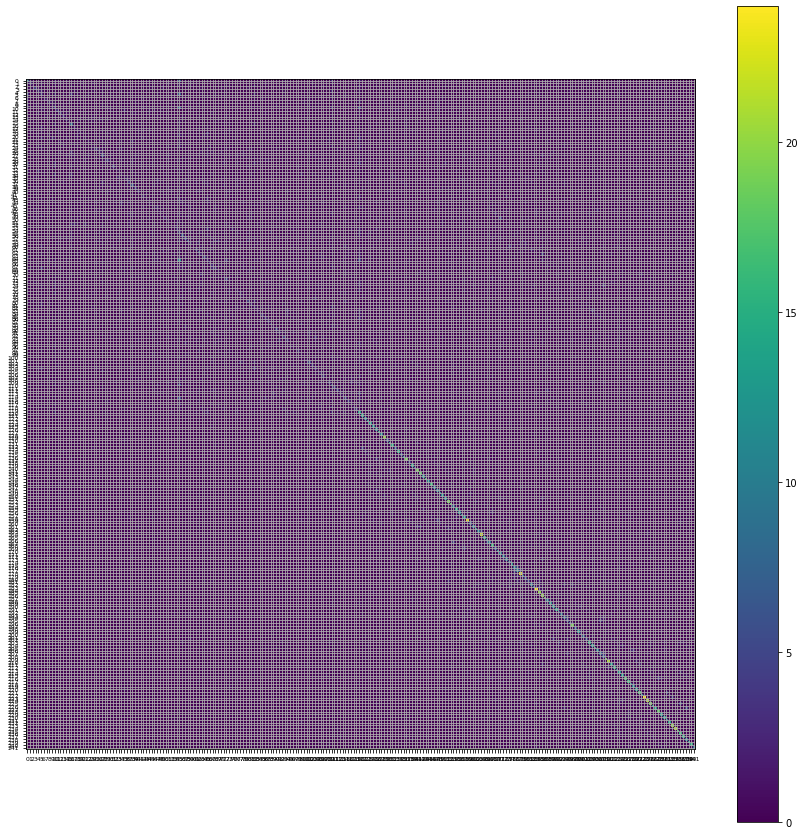

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cf(confmat):
    import numpy as np
    import matplotlib.pyplot as plt

#     confmat=np.random.rand(90,90)
    ticks=np.linspace(0, 241,num=242)
    plt.figure(figsize=(15, 15))
    plt.imshow(confmat, interpolation='none')
    plt.colorbar()
    plt.xticks(ticks,fontsize=6)
    plt.yticks(ticks,fontsize=6)
    plt.grid(True)
    plt.show()

cf_matrix = confusion_matrix(Ys, y_preds)
plot_cf(cf_matrix)


In [1]:
from environment.drawer import Drawer
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_test(drawer, strokes=32):
    actions = np.random.randint(0, 242, strokes)
    for action in actions:
        drawer.do_action(action)
        
    return drawer.get_canvas()

def get_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (84,84))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = 1-(img / 255)
    print(img)
    img = np.array(img, dtype=np.float)
    print(img.shape, type(img), img.dtype)
    return img

[[0.         0.         0.         ... 0.94901961 0.76862745 0.13333333]
 [0.         0.         0.         ... 0.03921569 0.00784314 0.00392157]
 [0.         0.         0.         ... 0.00392157 0.00392157 0.00392157]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(84, 84) <class 'numpy.ndarray'> float64
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


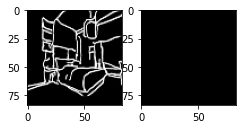

In [6]:
from copy import deepcopy

drawer_test = Drawer()
drawer_test.reset()
drawer_test.set_pen_position((40,40))
strokes = 200

drawer_ref = deepcopy(drawer_test)
# Test using random stroke
# ref = generate_test(drawer_ref, strokes)

# Test using image
ref = get_image('../Sketch/PhotoSketch/Exp/PhotoSketch/Results/bedroom.png')
drawer_ref.set_canvas(ref)


fig=plt.figure(figsize=(16, 8))
cols = 8
rows = 1
fig.add_subplot(rows, cols, 1)
plt.imshow(ref, cmap='gray')
fig.add_subplot(rows, cols, 2)
print(drawer_test.get_canvas())
plt.imshow(drawer_test.get_canvas(), cmap='gray')

plt.show()
canvas = []

for i in range(strokes):
    # Prepare X
    dis = drawer_test.get_distance_map()
    col = drawer_test.get_color_map()
    cp = drawer_test.get_patch()
    rp = drawer_ref.get_patch(drawer_test.get_pen_position())
    x = np.stack( (ref, drawer_test.get_canvas(), dis, col), axis=2)
    p = np.stack( (cp, rp), axis=2)
    
    x = np.expand_dims(x, axis=0)
    p = np.expand_dims(p, axis=0)
    
    pred = model1.model.predict([x,p])
    action = np.argmax(pred)
    drawer_test.do_action(action)
    canvas.append(drawer_test.get_canvas())


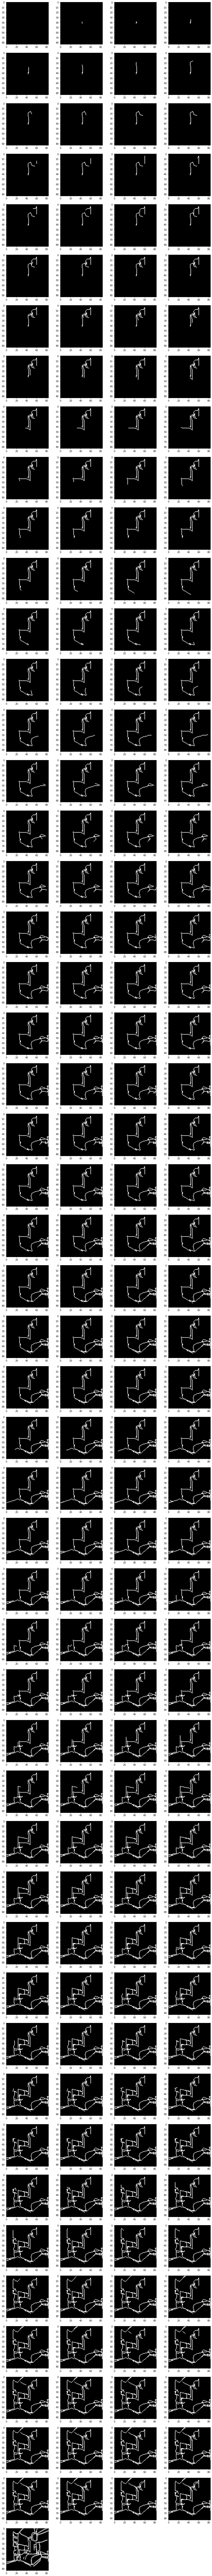

In [7]:
cols = 4
rows = strokes//cols + 1
fig=plt.figure(figsize=(4*cols, 4*rows))

for i in range(strokes):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(canvas[i], cmap='gray')
fig.add_subplot(rows, cols, strokes+1)
plt.imshow(ref, cmap='gray')
plt.show()

In [26]:
import cv2
import numpy as np
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('test_out/bedroom-' + name + '.avi',fourcc, 20.0, (84*2,84*1))
for i in range(strokes):
    images = (np.hstack((ref, canvas[i]))*255).astype("uint8")
    images = cv2.cvtColor(images, cv2.COLOR_GRAY2BGR)

#     cv2.imshow("Video", images)
#     cv2.imshow("patch", new_observation[4])
    out.write(images)

out.release()

In [14]:
model1.model.save(model_path)

In [5]:
model1.model = tf.keras.models.load_model(model_path)

In [ ]:
model.summary()